## Проект

Исследование закономерностей успешности компьютерных игр.

## Цель проекта

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## План действий

- изучить общую информацию о данных;
- подготовить данные для анализа;
- провести исследовательский анализ за все время и за актуальный период: мы рассмотрим сколько игр выпускалось за определенный период, как менялись продажи по платформам, какие платформы росли и падали по продажам, как продавались игры в разбивке по платформам, как влияли на продажи платформ отзывы пользователей и критиков, каково общее распределение игр по жанрам;
- составить портреты пользователей каждого региона;
- проверить гипотезы о пользовательских рейтингах некоторых платформ.

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import factorial

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод:**

Таблица показывает данные до 2016 года о продажах, оценках пользователей и экспертов, жанрах и платформах компьютерных игр. В ней 11 колонок и 16715 строк. В дальнейшем мы преобразуем типы данных в нескольких колонках и переименуем сами колонки.

## Предобработка данных

Приведем названия столбцов к нижнему регистру

In [5]:
df.columns = df.columns.str.lower()

Проверим пропуски и дубликаты в таблице по колонкам

In [6]:
df.duplicated().sum()

0

In [7]:
df.duplicated(subset=['name','platform','year_of_release']).sum()

2

In [8]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [9]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [10]:
df = df.dropna(subset=['name', 'platform', 'year_of_release'])

Преобразуем некоторые столбцы в необходимые нам типы данных.

In [11]:
df['year_of_release'] = df['year_of_release'].astype('int')

In [12]:
df.loc[df['user_score'] == 'tbd','user_score'] = np.nan

In [13]:
df['user_score'] = df['user_score'].astype('float')

Создадим отдельный столбец с общей суммой продаж.

In [14]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

Актуализируем данные по столбцу 'rating'.

In [15]:
df.loc[df['rating'] == 'K-A', 'rating'] = 'E'

**Вывод:**

Все столбцы таблицы приведены к нижнему регистру. В столбцах 'year_of_release' и 'user_score' были изменены типы данных на 'int' и 'float' соответственно.
    
В столбцах 'name', 'genre' и 'year_of_release' пропуски были удалены, потому что их невозможно ничем было заменить. Таких данных было достаточно мало и их удаление не повлияет на дальнейший анализ. В этих столбцах могли появиться пропуски по причине некорректной выгрузке данных. В остальных столбцах мы оставили пропуски, т.к. их досточно много и их удаление может исказить итоговый анализ.
    
По столбцу 'user_score' помимо NaN также были выявлены значения tbd. Это означает, что данные либо еще не были посчитаны, либо не были собраны. Их мы переименовали в NaN, чтобы облегчить дальнейшую работу с таблицей.
    
Далее мы добавили отдельный столбец с суммарными продажами во всех регионах 'sales_total'.
    
Проанализировав внешние источники информации, мы узнали, что в таблице есть неакутальные данные о рейтинге от организации ESRB. К примеру рейтинг 'K-A' относится к рейтингу 'E' (ранее рейтинг 'E' назывался рейтингом 'K-A', возможно при составлении данных забыли учесть эту замену). Поэтому мы подправили значения по столбцу 'rating', изменив неактуальные значения.

## Исследователький анализ данных

**Узнаем сколько игр выпускалось в разные годы и важны ли нам данные за все периоды**

Сгруппируем таблицу по наиболее выпускаемым играм за все годы и построим график.

Text(0.5, 1.0, 'Выпуск игр за разные годы')

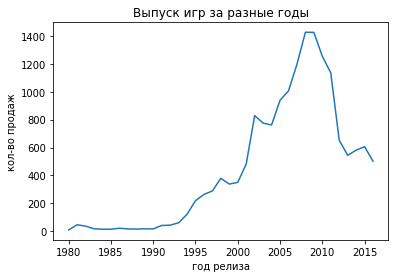

In [16]:
df_game_year = df.groupby('year_of_release')['name'].count().plot()
plt.xlabel('год релиза')
plt.ylabel('кол-во продаж')
plt.title('Выпуск игр за разные годы')

Самое большое кол-во игр выпускалось за период 2005-2011 гг, а наменьшее - за 1980-1993 гг.

Для дальнейшего анализа таблицы данные за все периоды нам не важны, досточно взять 3 последних года (т.е. 2014, 2015 и 2016 гг). Это обусловлено тем, что в данных много информации про старые игры, которые к 2016 году потеряли свою популярность.

**Узнаем как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Так мы узнаем за какой характерный срок появляются новые и исчезают старые платформы**

Сгруппируем таблицу по платформам с наибольшими продажами.

In [17]:
df_platform_sales = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
df_platform_sales

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.76
GB       254.43
XB       251.57
NES      251.05
N64      218.01
SNES     200.04
GC       196.73
XOne     159.32
2600      86.48
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64

Из сгруппированной выше таблицы выделим топ 6 платформ с наибольшими продажами: PS2, X360, PS3, Wii, DS и PS. Далее, создадим сводную таблицу, где покажем кол-во продаж по только по выбранным нами платформам и построим по ним диаграмму по годам.

Text(0.5, 1.0, 'Распределение продаж по платформам')

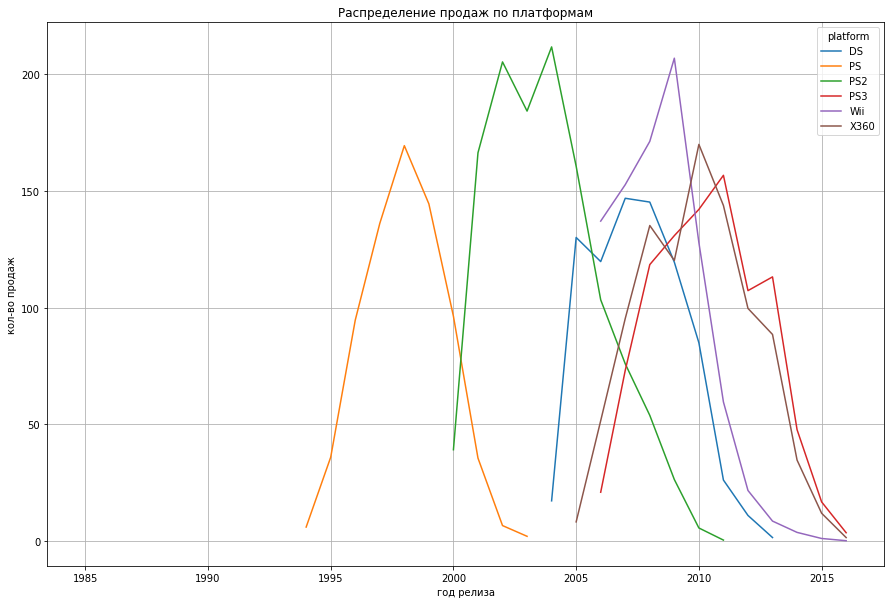

In [18]:
df_platform = df.query("platform == ['PS2', 'X360', 'PS3', 'Wii', 'DS','PS']")
df_platform_pivot = df_platform.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
df_platform_pivot.plot(grid=True, figsize=(15,10))
plt.xlabel('год релиза')
plt.ylabel('кол-во продаж')
plt.title('Распределение продаж по платформам')

Анализируя построенную нами диаграмму распределения продаж по топ 6 платформам видим, что кол-во продаж у разных платформ в разные годы значительно разнятся.

Платформа PS продавала игры с 1994 по 2003 гг, топ продаж произошел в 1998 на отметке 170 млн проданных копий.

Платформа PS2 продавала игры с 2000 по 2011 гг, топ продаж произошел в 2002 и 2004 гг на отметке 210 млн проданных копий.

Платформа DS продавала игры с 2004 по 2013 гг, топ продаж произошел в 2007 на отметке почти 150 млн проданных копий.

Платформа Х360 продавала игры с 2005 по 2016 гг, топ продаж произошел в 2010 на отметке 165 млн проданных копий.

Платформа PS3 продавала игры с 2006 по 2016 гг, топ продаж произошел в 2011 на отметке 155 млн проданных копий.

Платформа Wii продавала игры с 2006 по 2016 гг, топ продаж произошел в 2009 на отметке 205 млн проданных копий.

Дольше всех продажи осуществляли платформы PS2, DS и X360 - 11 лет.
Наибольшее кол-во проданных копий зафиксированно у платформ PS2 и Wii - 210 и 205 млн копий соответственно.

Далее, создадим сводную таблицу, в которой посчитаем примерный срок жизни платформ.

In [19]:
df_platform_year = df.pivot_table(index='platform',values='year_of_release', aggfunc={'year_of_release':['min', 'max']})
df_platform_year['life'] = df_platform_year['max'] - df_platform_year['min']
print(df_platform_year)
df_platform_year['life'].mean()

           max   min  life
platform                  
2600      1989  1980     9
3DO       1995  1994     1
3DS       2016  2011     5
DC        2008  1998    10
DS        2013  1985    28
GB        2001  1988    13
GBA       2007  2000     7
GC        2007  2001     6
GEN       1994  1990     4
GG        1992  1992     0
N64       2002  1996     6
NES       1994  1983    11
NG        1996  1993     3
PC        2016  1985    31
PCFX      1996  1996     0
PS        2003  1994     9
PS2       2011  2000    11
PS3       2016  2006    10
PS4       2016  2013     3
PSP       2015  2004    11
PSV       2016  2011     5
SAT       1999  1994     5
SCD       1994  1993     1
SNES      1999  1990     9
TG16      1995  1995     0
WS        2001  1999     2
Wii       2016  2006    10
WiiU      2016  2012     4
X360      2016  2005    11
XB        2008  2000     8
XOne      2016  2013     3


7.612903225806452

Характерный срок, за который появляются новые платформы и исчезают старые - приблизительно 7,5 лет.

In [20]:
# код ревьюера
df.groupby('platform')['year_of_release'].nunique().mean()

7.67741935483871

**Возьмем данные за соответствующий актуальный период. Актуальный период определим самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.**

Возьмем 2014-2016 гг за соответствующий актуальный период, потому что эти годы смогут помочь построить точный прогноз на 2017 г. В работе не будем учитывать предыдущие годы. Поэтому ниже мы перезапишем датасет с данными только за 2014-2016 гг.

In [21]:
df = df.query("2014 <= year_of_release <= 2016")

**Узнаем какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ.**

Сгруппируем таблицу по платформам с наибольшими продажами за 2014-2016 гг.

In [22]:
df_actual = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
df_actual

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: total_sales, dtype: float64

Text(0.5, 1.0, 'Распределение продаж по платформам за 2014-2016 гг')

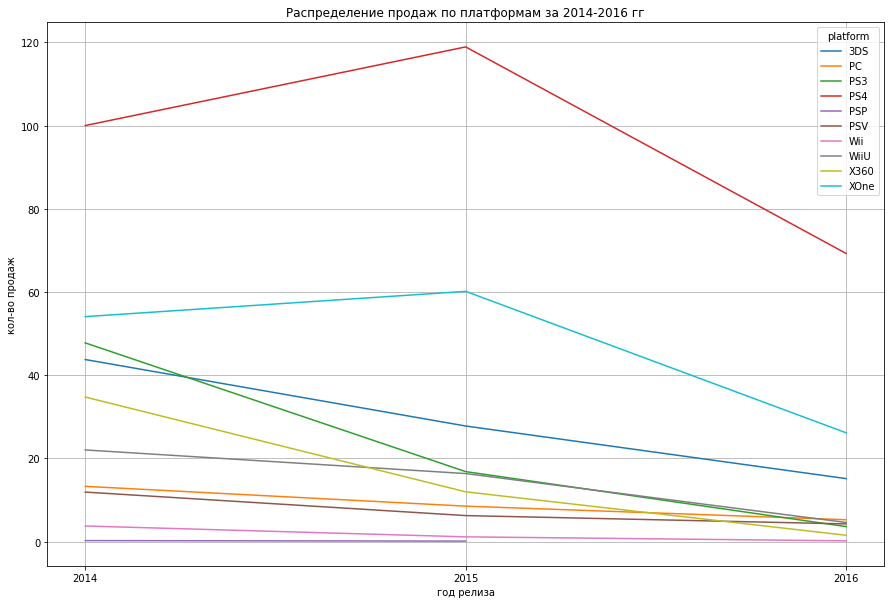

In [23]:
df_actual_all = df.pivot_table(index='year_of_release',columns='platform',values='total_sales', aggfunc='sum').plot(grid=True, figsize=(15,10))
plt.xticks(range(2014,2017))
plt.xlabel('год релиза')
plt.ylabel('кол-во продаж')
plt.title('Распределение продаж по платформам за 2014-2016 гг')

Первое, что бросается в глаза, глядя на график, это то, что с начала 2015 года идет спад в объемах продаж игр на всех платформах, хотя за 2014 г наблюдался рост по двум лидирующим платформам. Возможно это происходит из-за того, что в изначальной таблице данные за 2016 г неполные. Однако несмотря на спад, лидером была и остается платформа PS4. Второе место по объемам продаж на протяжении трех последних лет занимает платформа XOne, а третье - 3DS. Самые малые продажи за 2014 г наблюдаются у платформы PSP, а за 2015 г - у платформы Wii.

Далее проанализируем кол-во продаж только по двум самым продаваемым платформам (PS4 и XOne) за 2014-2016 гг, создав сводную таблицу и построив по ней диаграмму.

Text(0.5, 1.0, 'Распределение продаж по платформам PS4 и XOne за 2014-2016 гг')

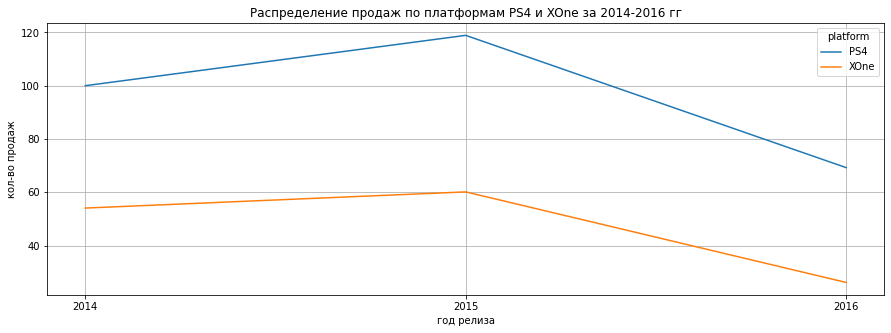

In [24]:
df_actual_best = df.query("platform == ['PS4', 'XOne']")
df_actual_best_pivot = df_actual_best.pivot_table(index='year_of_release',columns='platform',values='total_sales', aggfunc='sum').plot(grid=True, figsize=(15,5))
plt.xticks(range(2014,2017))
plt.xlabel('год релиза')
plt.ylabel('кол-во продаж')
plt.title('Распределение продаж по платформам PS4 и XOne за 2014-2016 гг')

По графику видим, что продажи обеих платформ росли в течение 2014 г: у платформы PS4 продажи выросли на 20%, а у XOne - на 9%. Но с начала 2015 г продажи стремительно падали. В начале 2015 г кол-во продаж PS4 было зафиксировано на уровне 120 млн копий, а уже в концу года - на уровне 70 млн копий. XOne в начале 2015 г продавал 60 млн копий, а к концу года - около 15 млн копий.

Объемы продаж у PS4 за 2 года упали на 30%, а у XOne - на целых 80%.

**Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.**

Построим диаграмму размаха для всех платформ по продажам игр за 2014-2016 гг.

Text(0.5, 1.0, 'Продажи игр за 2014-2016 гг в разбивке по платформам')

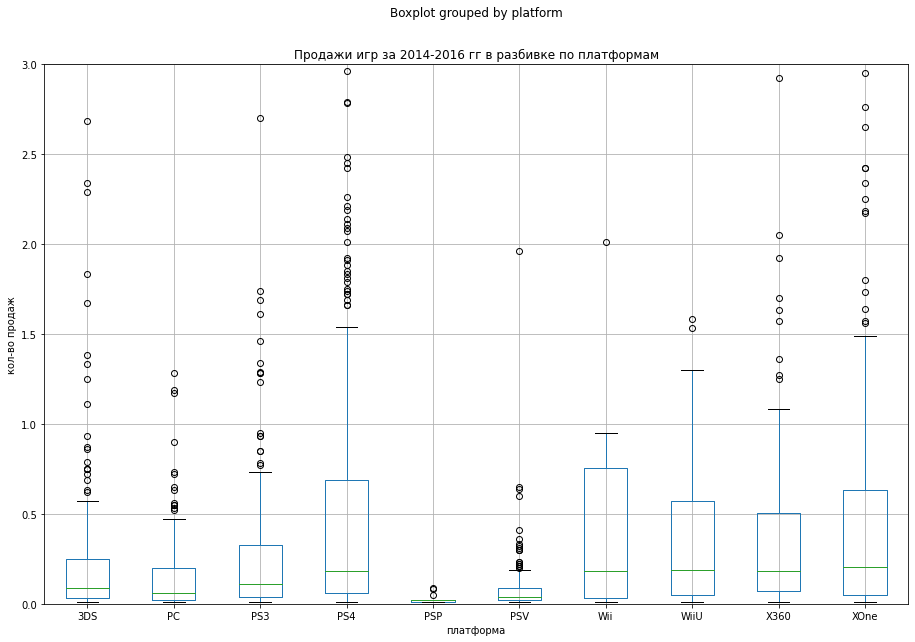

In [25]:
df.boxplot(by='platform', column='total_sales', figsize=(15,10))
plt.ylim(0,3)
plt.xlabel('платформа')
plt.ylabel('кол-во продаж')
plt.title('Продажи игр за 2014-2016 гг в разбивке по платформам')

Анализируя диаграмму размаха, видим, что бóльшая часть значений продаж по платформам лежит в диапазоне до 0.5 млн проданных копий. Самые высокие медианы у платформ WiiU, Wii, XOne и PS4, означающие, что у этих четырех платформ были самые высокие в среднем продажи: 0.23, 0.2, 0.2 и 0.15 млн копий соответственно. Самые длинные усы так же просматриваются у платформ XOne и PS4 из-за аномально больших значений проданных игр.

Большое количество выбросов значений продаж у платформ говорит о невероятно больших продажах, которые могут быть связаны с очень успешными рекламными кампаниями. Кроме того, нельзя оставить в стороне факт роста культа и всеобщей любви у подростков и молодых людей к определенным компьютерным играм в те или иные исторические времена, что тоже сильно влияло на продажи игр.

**Посмотрим как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.**

Возьмем самую популярную платформу PS4, у которой наблюдалось самое большое кол-во продаж за 2014-2016 гг. Построим по ней 2 таблицы рассеяния с отзывами пользователей и отзывами критиков и посчитаем коэффициенты корреляции.

Text(0.5, 1.0, 'Корреляция между отзывами пользователей и продажами у PS4')

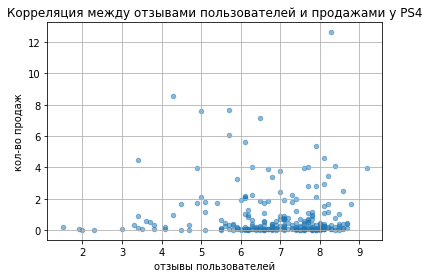

In [26]:
df_ps4 = df.query("platform == 'PS4'")
df_ps4.plot(x='user_score', y='total_sales', kind='scatter', grid=True, alpha=0.5)
plt.xlabel('отзывы пользователей')
plt.ylabel('кол-во продаж')
plt.title('Корреляция между отзывами пользователей и продажами у PS4')

По графику видим, что в основном у игр PS4 отзывы пользователей варьируются между 5.5 и 8.5 баллами. Можно считать, что пользователи были удовлетворены играми платформы PS4. Однако есть совсем незначительная доля отзывов от 1 до 5 баллов. Кол-во продаж игр практически одинаково почти на всей части графика, где баллы отзывов варьируются от 5 до 9.

In [27]:
df_ps4['user_score'].corr(df_ps4['total_sales'])

-0.040131589472697356

Коэффициент корреляции почти равен 0, что говорит о слабой связи между двумя факторами. С ростом положительных отзывов пользователей PS4, продажи особо не растут и не падают.

Text(0.5, 1.0, 'Корреляция между отзывами критиков и продажами у PS4')

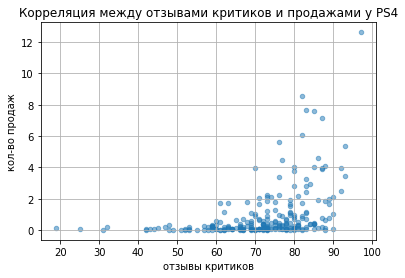

In [28]:
df_ps4.plot(x='critic_score', y='total_sales', kind='scatter', grid=True, alpha=0.5)
plt.xlabel('отзывы критиков')
plt.ylabel('кол-во продаж')
plt.title('Корреляция между отзывами критиков и продажами у PS4')

График показывает рост продаж игр на платформе PS4 с ростом положительных отзывов критиков. В основном отзывы критиков варьируются между 60 и 80 баллами, что можно считать хорошими оценками для игр. Оценки ниже 40 баллов так же наблюдаются, но в очень малом количестве.

In [29]:
df_ps4['critic_score'].corr(df_ps4['total_sales'])

0.40266141068104083

Коэффициент корреляции положителен, что говорит о тесной связи двух факторов. Это еще раз доказывает тот факт, что с ростом положительных отзывов критиков росли продажи самих игр на PS4.

**Соотнесем выводы с продажами игр на других платформах.**

Построим диаграммы рассеяния для платформы со средними продажами и для платформы с низкими продажами. Сделаем это для более справедливого сравнения. К примеру, выберем платформы PC и PSV. В конце сравним полученные результаты.

Сначала построим диаграммы рассеяния и посчитаем коэффициенты корреляции для платформы PC.

Text(0.5, 1.0, 'Корреляция между отзывами пользователей и продажами у PC')

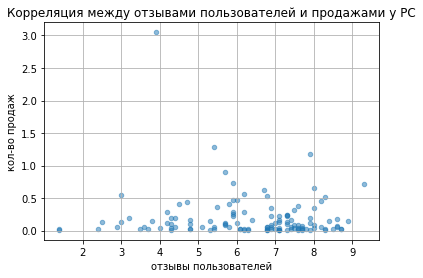

In [30]:
df_pc = df.query("platform == 'PC'")
df_pc.plot(x='user_score', y='total_sales', kind='scatter', grid=True, alpha=0.5)
plt.xlabel('отзывы пользователей')
plt.ylabel('кол-во продаж')
plt.title('Корреляция между отзывами пользователей и продажами у PC')

Т.к. платформа PC не такая популярная как PS4, то и отзывов у нее меньше. Большинство отзывов пользователей платформы PC варьируется от 7 до 8 баллов. Баллов ниже 3 практически нет. Так же видим некоторое кол-во больших продаж при хороших отзывах.

In [31]:
df_pc['user_score'].corr(df_pc['total_sales'])

-0.07159665703472451

Коэффициент корреляции положителен, что говорит о тесной связи двух факторов. C ростом положительных отзывов пользователей росли продажи самих игр на PC.

Text(0.5, 1.0, 'Корреляция между отзывами критиков и продажами у PC')

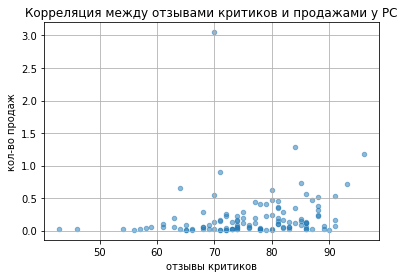

In [32]:
df_pc.plot(x='critic_score', y='total_sales', kind='scatter', grid=True, alpha=0.5)
plt.xlabel('отзывы критиков')
plt.ylabel('кол-во продаж')
plt.title('Корреляция между отзывами критиков и продажами у PC')

График показывает рост продаж игр на платформе PC с ростом положительных отзывов критиков. В основном отзывы критиков варьируются между 60 и 90 баллов, что можно считать как хорошие оценки для игр. Оценки ниже 60 баллов так же наблюдаются, но в очень малом кол-ве.

In [33]:
df_pc['critic_score'].corr(df_pc['total_sales'])

0.17463413769350036

Коэффициент корреляции положителен, что говорит о тесной связи двух факторов. Хорошие отзывы критиков влияют на рост продаж так же, как хорошие отзывы пользователей - продажи игр на PC росли.

Далее построим диаграммы рассеяния и посчитаем коэффициенты корреляции для платформы PSV.

Text(0.5, 1.0, 'Корреляция между отзывами пользователей и продажами у PSV')

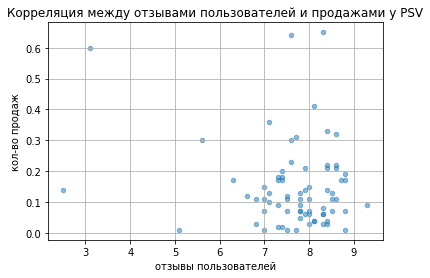

In [34]:
df_psv = df.query("platform == 'PSV'")
df_psv.plot(x='user_score', y='total_sales', kind='scatter', grid=True, alpha=0.5)
plt.xlabel('отзывы пользователей')
plt.ylabel('кол-во продаж')
plt.title('Корреляция между отзывами пользователей и продажами у PSV')

У платформы PSV гораздо бóльший разброс отзывов пользователей чем у предыдущих платформ. В основном отзывы варьируются от 7 до 9 баллов. Видим так же резкие увеличения объемов продаж и при отзывах пользователей в 7 баллов, и при отзывах в 9 баллов.

In [35]:
df_psv['user_score'].corr(df_psv['total_sales'])

-0.16845504978064446

Коэффициент корреляции почти равен 0, что говорит о слабой связи между двумя факторами. Объемы продаж примерно на одинаковом уровне и при отзывах пользователей в 7 баллов, и при отзывах в 9 баллов. Такой же вывод мы сделали, опираясь на диаграмму.

Text(0.5, 1.0, 'Корреляция между отзывами критиков и продажами у PSV')

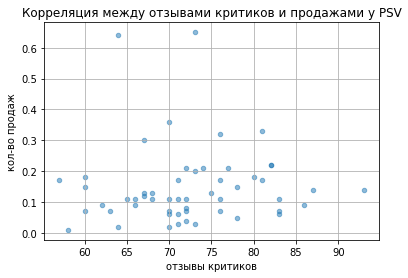

In [36]:
df_psv.plot(x='critic_score', y='total_sales', kind='scatter', grid=True, alpha=0.5)
plt.xlabel('отзывы критиков')
plt.ylabel('кол-во продаж')
plt.title('Корреляция между отзывами критиков и продажами у PSV')

График корреляции между отзывами критиков и продажами примерно такой же как на графике выше. Оценки критиков варьируются примерно от 70 до 75 баллов.

In [37]:
df_psv['critic_score'].corr(df_psv['total_sales'])

0.04266490657009526

Коэффициент корреляции почти равен 0, что говорит о слабой связи между двумя факторами. С ростом положительных отзывов критиков, объем продаж не растет, и не падает. Объем продаж остается примерно на одинаковом уровне вне зависимости от отзывов критиков.

**Вывод:**

Сравним корреляцию у самой популярной платформы PS4 с корреляцией менее популярных платформ: PC и PSV.

Напомним, что у платформы PS4 корреляция между отзывами критиков и ростом продаж была сильнее чем между отзывами пользователей и объемами продаж. На рост продаж сильнее влияли именно отзывы критиков.

Что касается средней по продажам платформы PC, то результат получился такой же - рост продаж совершался благодаря положительным отзывам именно критиков.

У платформы с низкими продажами PSV связь между отзывами критиков и продажами была такая же низкая как свзяь между отзывами пользователей и продажами. 

В целом можно сделать вывод, что отзывы критиков влияют на рост объема продаж сильнее чем отзывы пользователей.

**Посмотрим на общее распределение игр по жанрам. Опишем самые прибыльные жанры и факторы выделения жанров с высокими и низкими продажами.**

Построим диаграмму размаха для всех жанров за 2014-2016 гг.

Text(0.5, 1.0, 'Продажи игр за 2014-2016 гг в разбивке по жанрам')

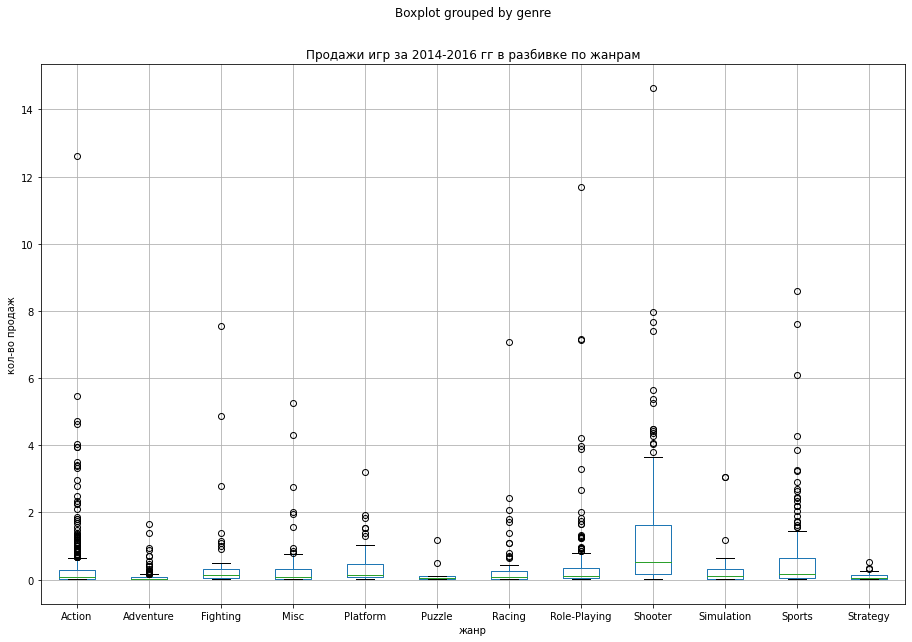

In [38]:
df.boxplot(column='total_sales', by='genre', figsize=(15,10))
#plt.ylim(0,3)
plt.xlabel('жанр')
plt.ylabel('кол-во продаж')
plt.title('Продажи игр за 2014-2016 гг в разбивке по жанрам')

Анализируя диаграмму размаха, видим, что бóльшая часть значений продаж по жанрам лежит в диапазоне до 0.2 млн проданных копий. Самая высокая медиана наблюдается у жанра Shooter. Это означает, что у игр с этим жанром были самые высокие в среднем продажи, а именно: 0.5 млн копий. Самые длинные усы тоже просматриваются у жанра Shooter из-за аномально высоких объемов продаж. Возможно, это объясняется тем, что с этим жанром было выпущено очень много игр с большими и успешными рекламными кампаниями.

Сгруппируем данные чтобы посмотреть общее кол-во игр тех или иных жанров.

In [39]:
df.groupby('genre')['name'].count().sort_values(ascending=False)

genre
Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: name, dtype: int64

Анализируя сгруппированную таблицу, видим, что больше всего выпускалось игр с жанром Action. За 2014-2016 гг таких игр начитывалось 691 шт. На втором месте по популярности - жанр Role-Playing. Кол-во игр с таким жанром насчитывалось 221 шт. Третье место занимает жанр Adventure (185 игр).

Наименее популярным жанром был Puzzle. Таких игр насчитывалось всего 14 шт.

Далее поcтроим сводную таблицу по жанрам с медианными значениями продаж и построим график.

Text(0.5, 1.0, 'Распределение жанров по продажам за 2014-2016 гг')

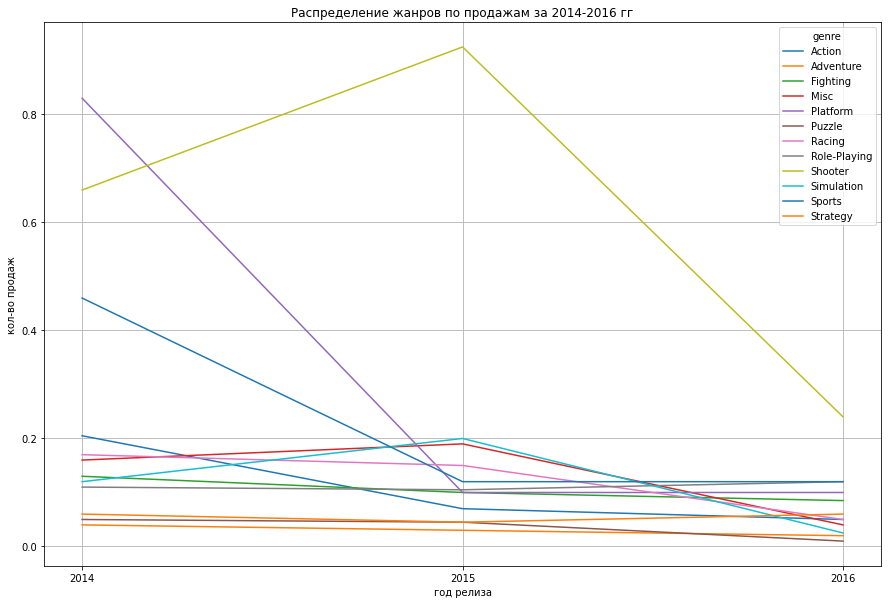

In [40]:
df_genre_pivot = df.pivot_table(index='year_of_release',columns='genre',values='total_sales', aggfunc='median').plot(grid=True, figsize=(15,10))
plt.xticks(range(2014,2017))
plt.xlabel('год релиза')
plt.ylabel('кол-во продаж')
plt.title('Распределение жанров по продажам за 2014-2016 гг')

В начале 2014 г лучше всего продавались игры с жанром Platform, медианное значение продаж было на отметке чуть больше 0.8 млн копий. В течение 2014-2015 гг этот жанр терял популярность и к концу 2015 г медианный объем продаж упал до 0.1 млн копий. В 2015 г самые большие продажи были у жанра Shooter. Несмотря на спад медианного объема продаж на 72%, этот жанр оставался самым продаваемым.

Жанры Adventure, Strategy и Puzzle продавались на протяжении обоих годов примерно одинаково мало. Их медианное значение продаж было менее 0.1 млн копий. По сравнению с наиболее популярными жанрами, эти показатели совсем малы.

## Портет пользователя каждого региона

**Определим для пользователя каждого региона (NA, EU, JP): самые популярные платформы (топ-5).**

Создадим сводную таблицу по популярности платформ в регионах. Далее мы оставим только топ-5 платформ, а остальные объединим в отдельную категорию 'other', и построим круговые диаграммы.

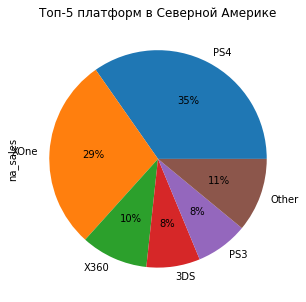

In [41]:
pivot_na_platform = df.pivot_table(index='platform', values='na_sales', aggfunc='sum')

top_na_platform = pivot_na_platform.nlargest(5, 'na_sales')['na_sales']

other_na_platform = pivot_na_platform['na_sales'].sum() - top_na_platform.sum()
top_na_platform['Other'] = other_na_platform

top_na_platform.plot(kind='pie', y='na_sales', autopct='%1.0f%%', legend=False, figsize=(15, 5))
plt.title('Топ-5 платформ в Северной Америке')

plt.show()

Самой популярной платформой в Северной Америке является PS4 (35%), на втором месте по популярности - платформа XOne c 29%. 10% занимает платформа X360. Четвертое и пятое места с одинаковой долей процентов делят 3DS и PS3. Другие консоли в сумме занимают 11% от всеобщей популярности.

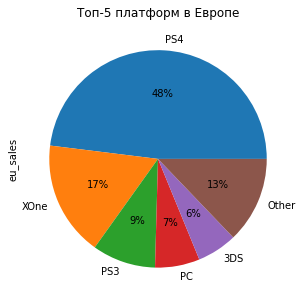

In [42]:
pivot_eu_platform = df.pivot_table(index='platform', values='eu_sales', aggfunc='sum')

top_eu_platform = pivot_eu_platform.nlargest(5, 'eu_sales')['eu_sales']

other_eu_platform = pivot_eu_platform['eu_sales'].sum() - top_eu_platform.sum()
top_eu_platform['Other'] = other_eu_platform

top_eu_platform.plot(kind='pie', y='eu_sales', autopct='%1.0f%%', legend=False, figsize=(15, 5))
plt.title('Топ-5 платформ в Европе')

plt.show()

В Европе почти половину площади диаграммы занимает консоль PS4. Гораздо менее популярна консоль XOne с 17%. Третье место занимает платформа PS3 - 9%. PC и 3DS наименее популярны в Европе.

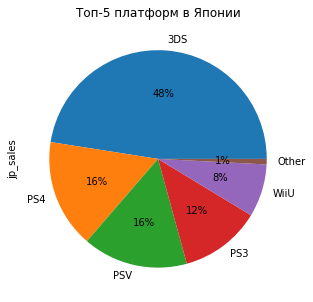

In [43]:
pivot_jp_platform = df.pivot_table(index='platform', values='jp_sales', aggfunc='sum')

top_jp_platform = pivot_jp_platform.nlargest(5, 'jp_sales')['jp_sales']

other_jp_platform = pivot_jp_platform['jp_sales'].sum() - top_jp_platform.sum()
top_jp_platform['Other'] = other_jp_platform

top_jp_platform.plot(kind='pie', y='jp_sales', autopct='%1.0f%%', legend=False, figsize=(15, 5))
plt.title('Топ-5 платформ в Японии')

plt.show()

В Японии столько же процентов по популярности на первом месте занимает платформа 3DS, сколько в Европе - PS4, - целых 48%. Второе, третье и четвертые места примерно с одинаковой популярностью делят плафтормы PS4, PSV и PS3. Другие консоли занимают лишь 1% общей популярности.

**Вывод:**

Самой популярной платформой можно назвать PS4, потому что она стоит на первом месте по продажам в Северной Америке и Европе. Только в Японии эта платформа заняла второе место, уступив первое платформе 3DS. 

Далее, второe местo в Северной Америке и Европе по продажам занимает плафторма XOne. В Японии, как оказалось, эта платформа даже не входит в топ-5.

**Определим для пользователя каждого региона (NA, EU, JP): самые популярные жанры (топ-5).**

Создадим сводную таблицу по популярности жанров в регионах. Далее мы оставим только топ-5 жанров, а остальные объединим в отдельную категорию 'other', и построим круговые диаграммы.

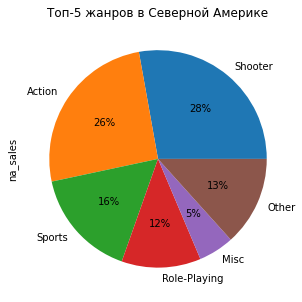

In [45]:
pivot_na_genre = df.pivot_table(index='genre', values='na_sales', aggfunc='sum')

top_na_genre = pivot_na_genre.nlargest(5, 'na_sales')['na_sales']

other_na_genre = pivot_na_genre['na_sales'].sum() - top_na_genre.sum()
top_na_genre['Other'] = other_na_genre

top_na_genre.plot(kind='pie', y='na_sales', autopct='%1.0f%%', legend=False, figsize=(15, 5))
plt.title('Топ-5 жанров в Северной Америке')

plt.show()

Практически одинаково популярными жанрами в Северной Америке являются Shooter (28%) и Action (26%). Sports занимает третье место (16%). Четвертое и пятое - Role-Playing и Misc соответственно.

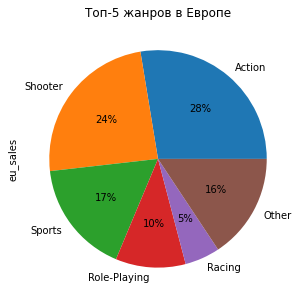

In [46]:
pivot_eu_genre = df.pivot_table(index='genre', values='eu_sales', aggfunc='sum')

top_eu_genre = pivot_eu_genre.nlargest(5, 'eu_sales')['eu_sales']

other_eu_genre = pivot_eu_genre['eu_sales'].sum() - top_eu_genre.sum()
top_eu_genre['Other'] = other_eu_genre

top_eu_genre.plot(kind='pie', y='eu_sales', autopct='%1.0f%%', legend=False, figsize=(15, 5))
plt.title('Топ-5 жанров в Европе')

plt.show()

В отличие от Северной Америки, в Европе больше предпочитают играть в Action. Жанр Shooter на втором месте с отрывом всего в 4%. Третье и четвертое места идентичны по популярности в Америке. А вот пятое место уже занимает жанр Racing.

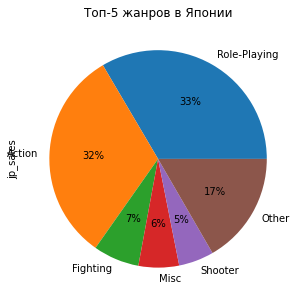

In [47]:
pivot_jp_genre = df.pivot_table(index='genre', values='jp_sales', aggfunc='sum')

top_jp_genre = pivot_jp_genre.nlargest(5, 'jp_sales')['jp_sales']

other_jp_genre = pivot_jp_genre['jp_sales'].sum() - top_jp_genre.sum()
top_jp_genre['Other'] = other_jp_genre

top_jp_genre.plot(kind='pie', y='jp_sales', autopct='%1.0f%%', legend=False, figsize=(15, 5))
plt.title('Топ-5 жанров в Японии')

plt.show()

В Японии одинаково любят играть в игры с жанрами Role-Playing (33%) и Action (32%). С сильным отрывом на третьем, четвертом и пятом местах расположились жанры Fighting, Misc и Shooter соответственно.

**Вывод:**

Самыми популярными жанрами можно считать Shooter и Action, занимающие первое и второе места по популярности среди игроков в Северной Америке и Европе. В Японии Action так же занимает второе место, уступив первое жанру Role-Playing.

**Определим для пользователя каждого региона (NA, EU, JP): влияет ли рейтинг ESRB на продажи в отдельном регионе.**

Cгруппируем данные о рейтинге ESRB в регионах и построим круговые диаграммы.

Text(0.5, 1.0, 'Влияние рейтинга ESRB на продажи в NA')

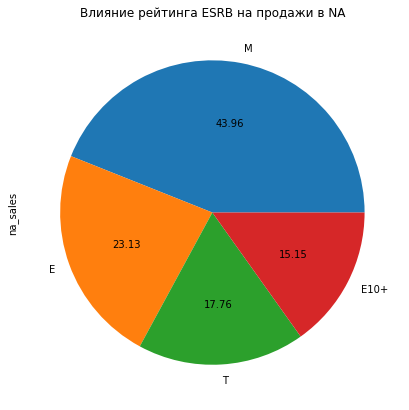

In [48]:
df_na_rating = df.groupby('rating')['na_sales'].sum().sort_values(ascending=False).plot(kind='pie',autopct='%.2f',figsize=(7,7))
plt.title('Влияние рейтинга ESRB на продажи в NA')

По диаграмме видим, что за 2015-2016 гг больше всего продаж в Северной Америке у игр с рейтингом M (для взрослых) - 41.13%. Почти в 2 раза меньше продажи с рейтингом E (для всех). Они составляют 23.25%. На 4% ниже продажи у игр с рейтингом T (подросткам). Самые малые продажи у игр с рейтингом E10+ (для всех от 10 лет и старше) - 16.63%.

Text(0.5, 1.0, 'Влияние рейтинга ESRB на продажи в EU')

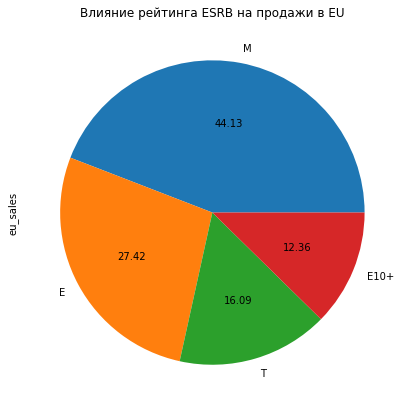

In [49]:
df_eu_rating = df.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).plot(kind='pie',autopct='%.2f',figsize=(7,7))
plt.title('Влияние рейтинга ESRB на продажи в EU')

Полученная нами диаграмма продаж в Европе практически идентична диаграмме продаж в Северной Америке. Отметим небольшое различие в доле продаж игр с рейтингом Е (для всех): в Европе он выше на 8%. Так же продажи игр с рейтингом E10+ (для всех от 10 лет и старше) ниже на 5% чем в Северной Америке.

Text(0.5, 1.0, 'Влияние рейтинга ESRB на продажи в JP')

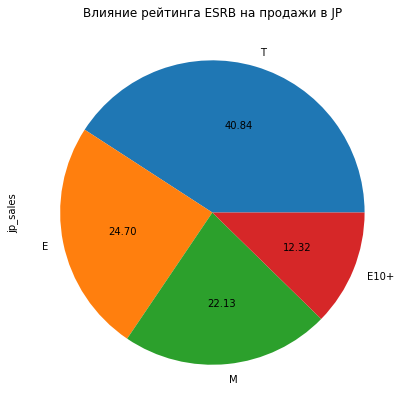

In [50]:
df_jp_rating = df.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).plot(kind='pie',autopct='%.2f',figsize=(7,7))
plt.title('Влияние рейтинга ESRB на продажи в JP')

В Японии за 2015-2016 гг больше всего продаж было у игр с рейтингом Т (подросткам) - 37.54%. На втором месте, как у Северной Америки и Европы, игры с рейтингом E (для всех). Их доля равна 25.6%. Продажи игр с рейтингом М (для взрослых) у Японии занимают третье место - 20.92%. Продажа игр с рейтингом E10+ (для всех от 10 лет и старше) аналогична продажам в Северной Америке.

**Вывод:**

Наибольшая доля продаж в Северной Америке и Европе составляют игры с рейтингом М (для взрослых). На втором месте - игры с рейтингом Е (для всех), на третьем - Т (подросткам). В Японии же на первом месте по продажам игры с рейтингом Т (подросткам), а на третьем, наоборот, - М (для взрослых).

## Проверка гипотез

**Гипотеза 1: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

Сформулируем гипотезы:
- Н(0) - средние пользовательные рейтинги XOne равны средним пользовательским рейтингам PC
- Н(1) - средние пользовательные рейтинги XOne не равны средним пользовательским рейтингам PC

Далее создадим 2 выборки: пользовательские рейтинги XOne и PC без учета пропусков.

In [51]:
xone = df.query("platform == 'XOne'")
xone = xone['user_score'].dropna()
xone

165      7.9
179      5.4
242      6.4
270      6.2
373      4.1
        ... 
16544    6.8
16597    6.0
16630    8.2
16643    6.6
16660    6.7
Name: user_score, Length: 165, dtype: float64

In [52]:
pc = df.query("platform == 'PC'")
pc = pc['user_score'].dropna()
pc

458      3.9
1530     5.4
1730     7.9
2303     5.7
2784     5.9
        ... 
16456    8.3
16463    6.8
16509    7.9
16518    1.4
16692    7.6
Name: user_score, Length: 122, dtype: float64

Проведем двухвыборочный t-тест для независимых выборок.

In [53]:
print('среднее выборки XOne:', np.mean(xone))
print('среднее выборки PC:', np.mean(pc))

alpha = 0.05
results = st.ttest_ind(xone,pc,alternative='two-sided',equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

среднее выборки XOne: 6.594545454545456
среднее выборки PC: 6.298360655737705
p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


Т.к. р-value оказалось больше уровня статистической значимости (alpha), то можно сделать вывод, что наблюдаемое значение достаточно близко к предполагаемому в нулевой гипотезе. Cредние пользовательные рейтинги XOne (6.54) примерно равны средним пользовательским рейтингам PC (6.29). Поэтому нулевая гипотеза не отвергается. 

**Гипотеза 2: средние пользовательские рейтинги жанров Action и Sports разные.**

Сформулируем гипотезы:
- Н(0) - средние пользовательные рейтинги жанра Action равны средним пользовательским рейтингам жанра Sports
- Н(1) - средние пользовательные рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports

Создадим 2 выборки: пользовательские рейтинги жанров Action и Sports без учета пропусков.

In [54]:
action = df.query("genre == 'Action'")
action = action['user_score'].dropna()
action

42       8.3
165      7.9
231      8.1
295      6.3
304      4.9
        ... 
16544    6.8
16597    6.0
16652    8.5
16660    6.7
16692    7.6
Name: user_score, Length: 297, dtype: float64

In [55]:
sports = df.query("genre == 'Sports'")
sports = sports['user_score'].dropna()
sports

77       4.3
94       5.0
143      5.7
264      4.5
314      6.7
        ... 
16120    6.3
16142    8.8
16146    6.9
16518    1.4
16643    6.6
Name: user_score, Length: 127, dtype: float64

Проведем двухвыборочный t-тест для независимых выборок.

In [56]:
print('среднее выборки Action:', np.mean(action))
print('среднее выборки Sports:', np.mean(sports))

alpha = 0.05
results = st.ttest_ind(action,sports,alternative='two-sided',equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

среднее выборки Action: 6.760606060606061
среднее выборки Sports: 5.2251968503937
p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Т.к. р-value оказалось меньше уровня статистической значимости (alpha), то можно сделать вывод, что наблюдаемое значение слишком далеко от предполагаемого в нулевой гипотезе. Средние пользовательские рейтинги жанра Action (6.8) больше чем средние пользовательские рейтинги жанра Sports (5.97). Поэтому нулевая гипотеза отвергается в пользу альтернативной: средние пользовательные рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports.

## Общий вывод

**Цель проекта** - выявить определяющие успешность игры закономерности для интернет-магазина «Стримчик». Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год.
________________

Непосредственно после **загрузки данных** и знакомства с таблицей мы узнали что она содержит данные до 2016 года о продажах, оценках пользователей и экспертов, жанрах и платформах компьютерных игр. В ней 11 колонок и 16715 строк.
________________

На этапе **предобработки данных** мы привели все названия столбцов к нижнему регистру. 

В столбцах 'year_of_release' и 'user_score' были изменены типы данных на 'int' и 'float' соответственно.
    
В столбцах 'name', 'genre' и 'year_of_release' пропуски были удалены, потому что их невозможно ничем было заменить. Таких данных было достаточно мало и их удаление не повлияло бы на дальнейший анализ. В остальных столбцах мы оставили пропуски, т.к. их досточно много и их удаление может исказить итоговый анализ.
    
По столбцу 'user_score' помимо NaN также были выявлены значения tbd. Это означает, что данные либо еще не были посчитаны, либо не были собраны. Их мы переименовали в NaN, чтобы облегчить дальнейшую работу с таблицей.
    
Далее мы добавили отдельный столбец с суммарными продажами во всех регионах 'sales_total'.
    
Проанализировав внешние источники информации, мы узнали, что в таблице есть неакутальные данные о рейтинге от организации ESRB. К примеру рейтинг 'K-A' относится к рейтингу 'E' (ранее рейтинг 'E' назывался рейтингом 'K-A', возможно при составлении данных забыли учесть эту замену). Поэтому мы подправили значения по столбцу 'rating', изменив неактуальные значения.
________________

На этапе **исследовательского анализа данных** мы выявили, что самое большое количество игр выпускалось за период 2005-2011 гг. Также мы выделили топ 6 платформ с наибольшими продажами за все время. Ими оказались платформы PS2, X360, PS3, Wii, DS и PS. Дольше всех продажи осуществляли платформы PS2, DS и X360 - целых 11 лет. Наибольшее количество проданных копий зафиксированно у платформ PS2 и Wii - 210 и 205 млн копий соответственно. Характерный срок, за который появляются новые платформы и исчезают старые - приблизительно 7,5 лет.

Для дальнейшей работы с таблицей было решено взять 3 последних года из данных (т.е. 2014, 2015 и 2016 гг). Это обусловлено тем, что в данных много информации про старые игры, которые к 2016 г потеряли свою популярность. Эти годы также смогут помочь построить точный прогноз на 2017 г.

Анализируя продажи за выбранный нами срок 2014-2016 гг, мы выявили существенный спад в объемах продаж игр на всех платформах к 2016 г. Однако, несмотря на это, лидером была и остается платформа PS4. Второе место по объемам продаж на протяжении двух последних лет занимает платформа XOne, а третье - 3DS. Объемы продаж остальных платформ были сильно ниже лидеров. Самые малые продажи за все время наблюдаются у платформ PSP и Wii.

Далее мы решили углубиться в анализ двух самых популярных платформ и узнали, что за 2 анализируемых года объемы продаж у PS4 упали на 30%, а у XOne - на целых 80%.

Построив диаграмму размаха, мы выявили, что бóльшая часть значений продаж по платформам лежит в диапазоне до 0.5 млн проданных копий. Самые высокие медианы у платформ WiiU, Wii, XOne и PS4, означающие, что у этих четырех платформ были самые высокие в среднем продажи: 0.23, 0.2, 0.2 и 0.15 млн копий соответственно. Самые длинные усы так же просматриваются у платформ XOne и PS4 из-за аномально больших значений проданных игр. Большое количество выбросов значений продаж у платформ говорит о невероятно больших продажах, которые могут быть связаны с очень успешными рекламными кампаниями. Кроме того, нельзя оставить в стороне факт роста культа и всеобщей любви у подростков и молодых людей к определенным компьютерным играм в те или иные исторические времена, что тоже сильно влияло на продажи игр.

Далее мы сравнивали корреляцию у самой популярной платформы PS4 с корреляцией менее популярных платформ: PC и PSV. У платформ PS4 и PC корреляции между отзывами критиков и ростом продаж были сильнее чем между отзывами пользователей и объемами продаж. У платформы с низкими продажами PSV связь между отзывами критиков и продажами была такая же низкая как связь между отзывами пользователей и продажами. В целом можно сделать вывод, что отзывы критиков влияют на рост объема продаж сильнее чем отзывы пользователей.

Самым продаваемым жанром по значению медианной прибыльности за 2014-2016 гг стал жанр Shooter. В начале 2014 г лучше всего продавались игры с жанром Platform, медианное значение продаж было на отметке чуть больше 0.8 млн копий. В течение 2014-2015 гг этот жанр терял популярность и к концу 2015 г медианный объем продаж упал до 0.1 млн копий. В 2015 г самые большие продажи были у жанра Shooter. Несмотря на спад медианного объема продаж на 72%, этот жанр оставался самым продаваемым.

Жанры Adventure, Strategy и Puzzle продавались на протяжении обоих годов примерно одинаково мало. Их медианное значение продаж было менее 0.1 млн копий. По сравнению с наиболее популярными жанрами, эти показатели совсем малы.

Анализируя самые популярные платформы для каждого региона, самой популярной платформой можно назвать PS4, потому что она стоит на первом месте по продажам в Северной Америке и Европе. Только в Японии эта платформа заняла второе место, уступив первое платформе 3DS. Второe местo в Северной Америке и Европе по продажам занимает плафторма XOne. В Японии, как оказалось, эта платформа даже не входит в топ-5.

Что касается самых популярных жанров для каждого региона, то самыми популярными можно считать Shooter и Action, занимающие первое и второе места по популярности среди игроков в Северной Америке и Европе. В Японии Action так же занимает первое место. Самыми непопулярными жанрами во всех трех регионах являются Strategy и Puzzle.

Рейтинг ESRB тоже влиял на продажи в отдельных регионах. Наибольшая доля продаж в Северной Америке и Европе составляют игры с рейтингом М (для взрослых). На втором месте - игры с рейтингом Е (для всех), на третьем - Т (подросткам). В Японии же на первом месте по продажам игры с рейтингом Т (подросткам), а на третьем, наоборот, - М (для взрослых).
________________

Итогом нашего анализа выступила **проверка гипотез** для выявления некоторых закономерностей.
В процессе исследования мы выявили, что:
- средние пользовательные рейтинги XOne (6.54) примерно равны средним пользовательским рейтингам PC (6.29);
- средние пользовательские рейтинги жанра Action (6.8) больше чем средние пользовательские рейтинги жанра Sports (5.97).
________________

**Рекомендации:**
Для рекламной кампании в 2017 г следует обратить внимание на такие жанры как Shooter, Platform, Action и Role-Playing, т.к. эти жанры были наиболее популярны за последние 2 года. Также стоит развивать рынок продажи платформ PS4, XOne и 3DS, т.к. эти платформы пользуются несколько лет подряд высоким спросом в трех глобальных регионах мира: Северной Америке, Европе и Японии. Вышеперечисленные платформы не собираются терять своей актуальности.

Особо важно обращать внимания на отзывы критиков на игры и платформы, потому что именно они сильно влияют на рост объемов продаж. Возрастные рейтинги также сильно влияют на объемы продаж, поэтому стоит обратить особое внимание на игры с рейтингом М (для взрослых) и с рейтингом Е (для всех), т.к. они продаются гораздо чаще остальных.